# Generalization with Multi Layer Perceptron (MLP) and scikit-learn
Using a Multi Layer Perceptron to recognize handwritten digits from Optical Recognition of Handwritten Digits Data Set (Lichman, 2003, UCI Machine Learning Repository)

Author: Patricio García

Subject: Tratamiento Inteligente de Datos, ESIT-ULL

License: GNU GPL 3

Date: 28/02/2020

References:
* Recognizing hand-written digits, scikit-learn: https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py
* Generalizacion con LVQ, Patricio García: https://gitlab.com/pgarcia/OptdigitsLVQNeurolab/-/blob/master/Generalizacion_con_LVQ.ipynb

## Carga de librerías
Se utilizan las librerías de numpy, matplotlib y sklearn {Si utilizan cualquier otra comentén específicamente parar qué}:

In [3]:
# Avoid division '/' differences with Python 3
from __future__ import division

# Library imports
# ------------
# Standard scientific Python imports
# sudo python -mpip install matplotlib
# sudo apt-get install python-tk
import numpy as np
import matplotlib.pyplot as plt

# Import from scikit-learn
from sklearn import datasets
# from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Import from datetime
from datetime import datetime


## Carga y visualización de datos
Se cargan a memoria los datos, leyendo una parte desde un fichero CSV y otra parta desde las propias librerías de datos de sklearn:

In [4]:
# Patterns load
# ------------
# The digits dataset, train set
digits = np.loadtxt("optdigits.tra", dtype=int, delimiter=',')

(n_samples, n_features) = digits.shape

# The digits dataset, test set
digits_test = datasets.load_digits()

n_samples_test = len(digits_test.images)

print(digits_test.DESCR)


.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each bloc

Se tratan de datos de dígitos escritos a manos, cada patrón representa un dígito mediante una matriz de 8x8 elementos con valores entre 0 y 16, además incluye una última característica indicando la categoría del dígito, un valor entre 0 y 9. Se puede obtener más información de los datos en su [repostorio oficial](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits).

El problema a resolver consistirá en identificar la clase del dígito, del 0 al 9, a partir de la matriz de entrada de 8x8.

Visualizamos a continuación 10 de los patrones {Intenten buscar para sus datos alguna manera de visualizarlos, aunque sea como mínimo una tabla numérica con algunos ejemplos}:

Showing first 10 digit images


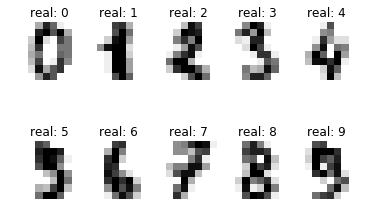

In [5]:
# Data visualization
# ------------
# have a look at the first test images
n_img_plt = 10

print("Showing first %d digit images" % n_img_plt)

_, axes = plt.subplots(2, n_img_plt//2)
images_and_labels = list(zip(digits_test.images[:n_img_plt], digits_test.target[:n_img_plt]))
for ax, (image, label) in zip(np.concatenate(axes), images_and_labels):
    ax.set_axis_off()
    _ = ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    _ = ax.set_title('real: %i' % label)

plt.show()

## Preprocesado de datos
Los datos de entrada serán las imágenes de 8x8 elementos convenientemente preprocesadas, como salida deseada se usa la categoría (el dígito que supuestamente se escribió). {En otros datos habrá de elegirse las entradas y salidas de acuerdo al problema a plantear. Para clasificación es necesario que las salidas sean algún dato categórico. Los errores producidos estarán muy relacionados con el problema a tratar, así por ejemplo detectar el sexo de una persona a partir de los síntomas de la enfermedad que tiene posiblemente sea más complicado que determinar la enfermedad a partir de los síntomas.}

Se realiza una partición de los datos, reservando el 75% de los datos del primer conjunto para entrenamiento, el otro 25% para validación y todos los datos cargados del segundo conjunto para test, {Si tiene un único conjunto de datos a dividir una partición de 50% entrenamiento, 25% validación y 25% test podría estar bien siempre que el conjunto de datos de entrenamiento no quede excesivamente grande o pequeño. Habrá de realizarse una validación con al menos un conjunto de entrenamiento y otro de validación si dispone de pocos datos, una partición de 75% y 25% podría estar bien en ese caso.} Se barajea el cojunto de entrenamiento.

No se realiza escalada de datos de entrada, ya que no se ha visto necesario. {El escalado o nomalización a utilizar es muy dependiente del tipo de problema y tipos de datos de que se disponga, consúltenme si tienen dudas.}

La distribución de datos por clases es bastante homogéneo, por lo tanto se puede considerar bien balanceado. {En el caso de que esto no sea así se podría plantear un balanceo de datos para evitar que las clases con menos datos obtengan malos resultados.}

In [7]:
# Data preprocessing
# ------------
train_size = 0.75
test_size = 1 - train_size

print("Preprocessing data, %d%% for training and %d%% for validation" % (train_size * 100, test_size * 100))

# inputs and flatten images
patterns_input = digits[:, :n_features-1]
input_test = digits_test.images.reshape((n_samples_test, -1))

# targets
patterns_target = digits[:, -1]
target_test = digits_test.target

# Split and shuffle patterns
input_train, input_valid, target_train, target_valid = train_test_split(
    patterns_input, patterns_target, train_size=train_size, test_size=test_size,
    random_state=0, shuffle=True)

# Print dimensions of data
print("Training set dimensions: " + str(input_train.shape))
print("Valid set dimensions: " + str(input_valid.shape))
print("Test set dimensions: " + str(input_test.shape))

Preprocessing data, 75% for training and 25% for validation
Training set dimensions: (2867, 64)
Valid set dimensions: (956, 64)
Test set dimensions: (1797, 64)


## Resultados iniciales Perceptrón Simple

Se entrena el modelo Perceptrón Simple con 30 iteraciones {. El número de iteraciones puede variar para sus datos, asegúrense que el error ha descendido y parece no poder descender mucho más.}:

In [8]:
# Modeling Perceptron
# ------------
max_iter = 30

print("Learning a Perceptron with %d maximum number of iterations and ..." % max_iter)

per = Perceptron(max_iter=max_iter, shuffle=False, random_state=0, verbose=True)
per.fit(input_train, target_train)

# Results
print("Printing Perceptron results")

predict_train = per.predict(input_train)
predict_valid = per.predict(input_valid)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))


Learning a Perceptron with 30 maximum number of iterations and ...
-- Epoch 1
Norm: 325.80, NNZs: 54, Bias: -4.000000, T: 2867, Avg. loss: 12.550401
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 400.77, NNZs: 55, Bias: -6.000000, T: 5734, Avg. loss: 7.445065
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 427.29, NNZs: 56, Bias: -7.000000, T: 8601, Avg. loss: 5.351238
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 487.58, NNZs: 55, Bias: -9.000000, T: 11468, Avg. loss: 6.353680
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 506.49, NNZs: 56, Bias: -10.000000, T: 14335, Avg. loss: 2.737356
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 533.96, NNZs: 56, Bias: -11.000000, T: 17202, Avg. loss: 1.447506
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 548.08, NNZs: 56, Bias: -11.000000, T: 20069, Avg. loss: 2.683641
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 583.52, NNZs: 56, Bias: -11.000000, T: 22936, Avg. loss: 2.440530
Total training time: 0.00 seco

Norm: 1114.93, NNZs: 54, Bias: -105.000000, T: 60207, Avg. loss: 64.874433
Total training time: 0.01 seconds.
-- Epoch 22
Norm: 1122.59, NNZs: 54, Bias: -109.000000, T: 63074, Avg. loss: 63.720265
Total training time: 0.01 seconds.
-- Epoch 23
Norm: 1133.73, NNZs: 54, Bias: -113.000000, T: 65941, Avg. loss: 68.489013
Total training time: 0.01 seconds.
-- Epoch 24
Norm: 1136.61, NNZs: 54, Bias: -119.000000, T: 68808, Avg. loss: 63.226020
Total training time: 0.01 seconds.
-- Epoch 25
Norm: 1149.04, NNZs: 54, Bias: -123.000000, T: 71675, Avg. loss: 63.487967
Total training time: 0.01 seconds.
-- Epoch 26
Norm: 1164.84, NNZs: 54, Bias: -128.000000, T: 74542, Avg. loss: 66.164981
Total training time: 0.01 seconds.
-- Epoch 27
Norm: 1161.89, NNZs: 54, Bias: -132.000000, T: 77409, Avg. loss: 68.907569
Total training time: 0.02 seconds.
-- Epoch 28
Norm: 1167.75, NNZs: 54, Bias: -137.000000, T: 80276, Avg. loss: 65.208232
Total training time: 0.02 seconds.
-- Epoch 29
Norm: 1177.34, NNZs: 54,

/home/patricio/.local/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


## Resultados iniciales MLP
Se entrena el modelo Perceptrón Multicapa (Multi Layer Perceptron, MLP) con 60 neuronas ocultas y 300 iteraciones {. El número de iteraciones puede variar para sus datos, asegúrense que el error de pérdidas de cada clase ha descendido y parece no poder descender mucho más}:

In [12]:
# Modeling MLP
# ------------
# Function to training and validate MLP
def MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, verbose):
    """
    Train and valid MLP every valid_cycles iterations
    """
    classes  = np.unique(target_train)
    loss_valid = []
    for i in range(max_iter//valid_cycles):
        for j in range(valid_cycles):
            out = mlp.partial_fit(input_train, target_train, classes)
            # Calculate loss function of valid set
        last_lost_valid = log_loss(target_valid, mlp.predict_proba(input_valid))
        loss_valid.append(last_lost_valid)
        if verbose:
            print("Iteration %d, train loss = %.8f, valid loss = %.8f" %
                  (mlp.n_iter_, mlp.loss_, last_lost_valid))
        if early_stopping and (i > 0) and (last_lost_valid > loss_valid[-2]): # Early stopping
            if verbose:
                print("Early stopping: Validation score did not improve")
            break
    if verbose: print(out)
    
    if verbose:
        # Visualizing the Cost Function Trajectory
        # (https://sdsawtelle.github.io/blog/output/week4-andrew-ng-machine-learning-with-python.html#Visualizing-the-Cost-Function-Trajectory)
        print("Visualizing the Cost Function Trajectory")
        plt.plot(range(1, len(mlp.loss_curve_)+1), mlp.loss_curve_, label='Train loss')
        plt.plot(range(valid_cycles,len(loss_valid)*valid_cycles+valid_cycles,valid_cycles), loss_valid, '-o', label='Valid loss')
        plt.xlabel('number of iterations')
        plt.ylabel('loss function')
        plt.legend(loc='upper right')
        plt.show()

Learning a MLP with 60 hidden neurons, 300 maximum number of iterations and 0.00100000 learning rate ...
Iteration 5, train loss = 0.65391149, valid loss = 0.58136926
Iteration 10, train loss = 0.26370699, valid loss = 0.26658190
Iteration 15, train loss = 0.16638651, valid loss = 0.18199506
Iteration 20, train loss = 0.11871485, valid loss = 0.14666919
Iteration 25, train loss = 0.08852137, valid loss = 0.12534668
Iteration 30, train loss = 0.06761784, valid loss = 0.11299355
Iteration 35, train loss = 0.05334735, valid loss = 0.10624288
Iteration 40, train loss = 0.04323733, valid loss = 0.10040241
Iteration 45, train loss = 0.03576837, valid loss = 0.09761504
Iteration 50, train loss = 0.02993376, valid loss = 0.09441293
Iteration 55, train loss = 0.02515124, valid loss = 0.09307554
Iteration 60, train loss = 0.02145791, valid loss = 0.09073773
Iteration 65, train loss = 0.01849561, valid loss = 0.08890110
Iteration 70, train loss = 0.01611649, valid loss = 0.08686508
Iteration 75, 

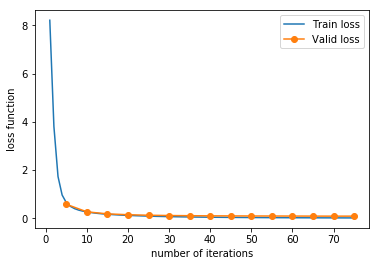

In [13]:
# Multilayer Percetron wiht n_hidden hidden neurons
n_hidden = 60
max_iter = 300
learning_rate_init = 0.001
valid_cycles = 5
early_stopping = True

print("Learning a MLP with %d hidden neurons, %d maximum number of iterations and %.8f learning rate ..." % (n_hidden, max_iter, learning_rate_init))

mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=learning_rate_init, shuffle=False, random_state=0, verbose=False)

MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, True)


In [14]:
# Intitial results
# ------------
print("Printing initial results")

predict_train = mlp.predict(input_train)
predict_valid = mlp.predict(input_valid)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))


Printing initial results
Train accuracy: 99.930%
Valid accuracy: 96.967%
Train confusion matrix:
[[275   0   0   0   0   0   0   0   0   0]
 [  0 288   0   0   0   0   0   0   1   0]
 [  0   0 284   0   0   0   0   0   0   0]
 [  0   0   0 295   0   0   0   0   0   0]
 [  0   0   0   0 299   0   0   0   0   0]
 [  0   0   0   0   0 290   0   0   0   0]
 [  0   0   0   0   0   0 281   0   0   0]
 [  0   0   0   0   0   0   0 292   0   0]
 [  0   0   0   0   0   0   0   0 280   1]
 [  0   0   0   0   0   0   0   0   0 281]]
Valid confusion matrix:
[[98  0  1  0  0  0  1  0  1  0]
 [ 0 95  1  0  0  0  0  2  2  0]
 [ 0  0 95  0  0  0  0  0  1  0]
 [ 0  0  0 94  0  0  0  0  0  0]
 [ 0  0  0  0 84  0  1  1  0  2]
 [ 0  0  0  1  0 82  0  0  1  2]
 [ 0  0  0  0  1  0 95  0  0  0]
 [ 0  0  1  0  0  0  0 94  0  0]
 [ 0  1  0  2  0  0  2  1 93  0]
 [ 0  0  0  0  2  0  0  1  1 97]]
Train classification report:
              precision    recall  f1-score   support

           0       1.00      1.00

Los resultados aparentan ser buenos, las matrices de cruces tiene la mayoría del peso en la diagonal principal y para todas las clases se obtiene buenas precisions y recalls. {En caso de que esto no sea así deberían plantearse qué problema puede estar ocurriendo y tratar de solventarlo.}

## Optimización ratio de aprendizaje
Para tratar de mejorar la velocidad del MLP se estudia distintos ratios de aprendizaje:

Learning rate optimization
Number of seconds for training: 4
Visualizing the Cost Function Trajectory with different learning rates


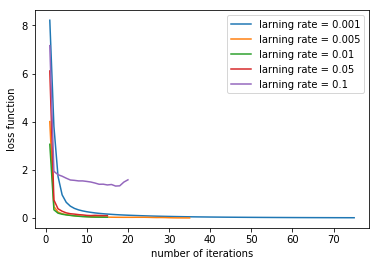

In [15]:
# Learning rate optimization
# ------------
# Test with different learning_rate_init
print("Learning rate optimization")

tests_learning_rate_init = [0.001, 0.005, 0.01, 0.05, 0.1]
activation = 'relu'
random_state = 0

now = datetime.now()
loss_curves =  []
for lr in tests_learning_rate_init:
    mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=lr, shuffle=False, random_state=random_state, verbose=False, activation=activation)
    MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, False)
    
    loss_curves.append(mlp.loss_curve_)

print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())

# Show results
print("Visualizing the Cost Function Trajectory with different learning rates")
for (lr, loss_curve) in zip(tests_learning_rate_init, loss_curves):
    plt.plot(range(1, len(loss_curve)+1), loss_curve, label='larning rate = ' + str(lr))

plt.xlabel('number of iterations')
plt.ylabel('loss function')
plt.legend(loc='upper right')
plt.show()


## Optimización arquitectura MLP
Para tratar de mejorar los resultados del MLP se estudia el número de neuronas ocultas más adecuadas, probando con distintos valores entre 10 y 190, repitiendo parar cada configuración 10 veces y quedándose con aquella de mayor precisión en el conjunto de validación {. El número de neuronas ocultas a estudiar deben adaptarlas a sus datos, de forma que haya variabilidad en los resultados obtenidos. Este estudio puede conllevar mucho tiempo de cómputo}:

In [16]:
# Architecture optimization
# ------------
print("Architecture optimization")

# Test MLP with differents number of hidden units and several repetitions
tests_n_hidden = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190]
n_reps = 10
# n_reps = 20
activation = 'relu'
# activation = 'logistic'
# learning_rate_init = 0.001
# learning_rate_init = 0.01
learning_rate_init = 0.005

now = datetime.now()
best_mlp = []
best_acc = 0.0
accs_train = []
accs_valid = []
for n_hidden in tests_n_hidden:
    max_acc_train = max_acc_valid = 0.0
    for random_state in range(n_reps):
        mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=learning_rate_init, shuffle=False, random_state=random_state, verbose=False, activation=activation)
        MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, False)
        
        acc_train = accuracy_score(target_train, mlp.predict(input_train))
        acc_valid = accuracy_score(target_valid,mlp.predict(input_valid))
        print("Seed = %d, train acc = %.8f, valid acc = %.8f, iterations = %d" % (random_state, acc_train, acc_valid, len(mlp.loss_curve_)))
        if (max_acc_valid < acc_valid):
            max_acc_valid = acc_valid
            max_acc_train = acc_train
            if (acc_valid > best_acc):
                best_acc = acc_valid
                best_mlp = mlp
    accs_train.append(max_acc_train)
    accs_valid.append(max_acc_valid)
    print("Number hidden units = %i, train acc = %.8f, max valid acc = %.8f" % (n_hidden, max_acc_train, max_acc_valid))

print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())
print("Best MLP valid accuracy: %.8f%%" % (best_acc * 100))
print("Best MLP: ", best_mlp)


Architecture optimization
Seed = 0, train acc = 0.98395535, valid acc = 0.95083682, iterations = 85
Seed = 1, train acc = 0.97697942, valid acc = 0.96025105, iterations = 65
Seed = 2, train acc = 0.97628183, valid acc = 0.95606695, iterations = 90
Seed = 3, train acc = 0.95919079, valid acc = 0.94665272, iterations = 60
Seed = 4, train acc = 0.96337635, valid acc = 0.93933054, iterations = 60
Seed = 5, train acc = 0.98918730, valid acc = 0.96338912, iterations = 70
Seed = 6, train acc = 0.97976979, valid acc = 0.95188285, iterations = 45
Seed = 7, train acc = 0.97418905, valid acc = 0.95292887, iterations = 50
Seed = 8, train acc = 0.96860830, valid acc = 0.93828452, iterations = 65
Seed = 9, train acc = 0.93965818, valid acc = 0.91527197, iterations = 60
Number hidden units = 10, train acc = 0.98918730, max valid acc = 0.96338912
Seed = 0, train acc = 0.99686083, valid acc = 0.97280335, iterations = 45
Seed = 1, train acc = 0.99895361, valid acc = 0.97803347, iterations = 45
Seed = 2,

Se observa que la arquitectura encontrada resulta ser de 110 neuronas en la capa oculta. Se visualizan los resultados de errores obtenidos con las distintas arquitecturas estudiadas {. Utilicen un rango de neuronas ocultas en que se vea empeoramiento del error en sus valores más bajos y variaciones poco significativas en valores más altos. Nunca la mejor rejilla encontrada debe estar en un extremo del intervalo}:

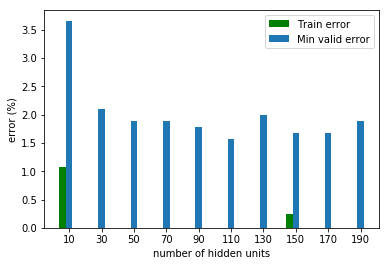

In [17]:
# Show results
width = 4
plt.bar(np.array(tests_n_hidden) - width, 100 *(1- np.array(accs_train)), color='g', width=width, label='Train error')
plt.bar(np.array(tests_n_hidden), 100 *(1- np.array(accs_valid)), width=width, label='Min valid error')
plt.xlabel('number of hidden units')
plt.ylabel('error (%)')
plt.xticks(np.array(tests_n_hidden), tests_n_hidden)
plt.legend(loc='upper right')
plt.show()


Se observa que neuronas ocultas entre 50 y 190 los resultados son similares, con variaciones poco significativas. {Si consideran mejor algún otro MLP no duden en utilizarlo.}

## Resultados finales mejor MLP
Se calculan los resultados finales para el mejor MLP obtenido, incluido el conjunto de test {Es importante no haber utilizado nunca el conjunto de test como guía para ajustar la arquitectura o parámetros}:

In [18]:
# Final results of best MLP
# ------------

print("Printing final results")

predict_train = best_mlp.predict(input_train)
predict_valid = best_mlp.predict(input_valid)
predict_test = best_mlp.predict(input_test)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print("Test accuracy: %.3f%%" % (accuracy_score(target_test, predict_test) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))
print("Test confusion matrix:")
print(confusion_matrix(target_test, predict_test))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))
print("Test classification report:")
print(classification_report(target_test, predict_test))


Printing final results
Train accuracy: 100.000%
Valid accuracy: 98.431%
Test accuracy: 96.995%
Train confusion matrix:
[[275   0   0   0   0   0   0   0   0   0]
 [  0 289   0   0   0   0   0   0   0   0]
 [  0   0 284   0   0   0   0   0   0   0]
 [  0   0   0 295   0   0   0   0   0   0]
 [  0   0   0   0 299   0   0   0   0   0]
 [  0   0   0   0   0 290   0   0   0   0]
 [  0   0   0   0   0   0 281   0   0   0]
 [  0   0   0   0   0   0   0 292   0   0]
 [  0   0   0   0   0   0   0   0 281   0]
 [  0   0   0   0   0   0   0   0   0 281]]
Valid confusion matrix:
[[ 99   0   1   0   0   0   1   0   0   0]
 [  0  99   0   0   0   0   0   1   0   0]
 [  0   0  95   0   0   0   1   0   0   0]
 [  0   0   0  94   0   0   0   0   0   0]
 [  0   0   0   0  84   0   1   1   0   2]
 [  0   0   0   1   0  83   0   0   0   2]
 [  0   1   0   0   0   0  95   0   0   0]
 [  0   0   0   0   0   0   0  95   0   0]
 [  0   0   0   0   0   0   2   0  97   0]
 [  0   0   0   0   1   0   0   0   0 1

Se observa que los resultados finales del mejor MLP obtenido para el conjunto de validación mejoran respecto al los resultados iniciales en un 1,46%, mejorando la generalización respecto al CPN inicial. El error final parar el conjunto de test es un 1,44% peor que el conjunto de validación. En la matriz de confusión y el informe de clasificación del conjunto de test se aprecia que todas la clases se reconocen mas o menos bien, la clase con mayores problema de reconocimiento es la que corresponde al dígito 8.

Se muestran también las curvas ROC para el conjunto de test, en ella también se puede ver que la clase del dígito 8 es la peor predicha:

Printing ROC curves of test set


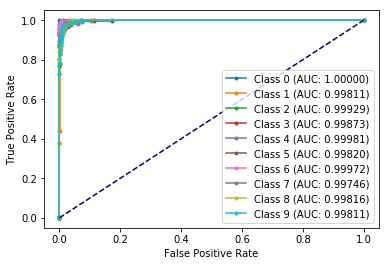

In [19]:
# ROC curves of test set
mlp_probs = mlp.predict_proba(input_test)
classes  = np.unique(target_train)
mlp_auc = []
mlp_fpr = []
mlp_tpr = []
for cla in classes:
    mlp_auc.append(roc_auc_score(target_test==cla, mlp_probs[:,cla]))
    fpr, tpr, _ = roc_curve(target_test==cla, mlp_probs[:,cla])
    mlp_fpr.append(fpr)
    mlp_tpr.append(tpr)

print("Printing ROC curves of test set")
# plot the roc curve for the model
for cla in classes:
    # plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(mlp_fpr[cla], mlp_tpr[cla], marker='.', label='Class %d (AUC: %.5f)' % (cla, mlp_auc[cla]))

# axis labels
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


Finalmente se muestran imágenes de distintos errores producidos en patrones del conjunto de test pertenecientes a la clase real 8:

Showing first 8 errors of real class 8


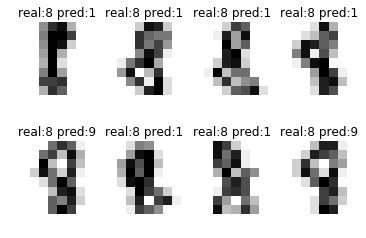

In [21]:
# Show errors on real class 8
real_class = 8
indxs = np.where(digits_test.target == real_class)[0]
indxs_err = indxs[(np.where(predict_test[(indxs)] != real_class)[0])]
preds_err = predict_test[(indxs_err)]
n_img_plt = 8

print("Showing first %d errors of real class %d" % (n_img_plt, real_class))

_, axes = plt.subplots(2, n_img_plt//2)
images_and_labels = list(zip(digits_test.images[(indxs_err)], digits_test.target[(indxs_err)], preds_err))
for ax, (image, label1, label2) in zip(np.concatenate(axes), images_and_labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('real:%i pred:%i' % (label1, label2))

plt.show()


## Conclusiones
El error final parar el conjunto de test, mucho peor que el conjunto de validación, puede estar justificado en parte debido a que los autores (escritores) del conjuntos de test son distintos a los autores de los conjuntos de entrenamieto y validación, donde si son los mismos. Los problemas que se aprecia que con el dígito 8 resultas ser lógicos, en la medida que la representación de un número tan denso en una matriz tan escasa resulta complicada, como se observa en la imagne de dichos errores. Esto nos induce a pensar que utilizando matrices mas grandes, como por ejemplo las utilizadas en el conjunto de datos MINIST, se podrían obtener resultados aún mejores.

Este resultado final parece bastante aceptable, y por ejemplo supera en 3,07% al mejor resultado obtenido en la publicación (Tang, Ponnuthurai, Suganthan, Yao and Qin, 2005) (93,93% de accurracy con WLDR 9d). {Si pueden comparara los resultados por los publicados por otros autores, mucho mejor.}